<a href="https://www.kaggle.com/code/vshakhlin/innopolis-global-ai-challenge-2023-ipynb?scriptVersionId=135440471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We tried several approaches:
1. Use SAM (https://github.com/facebookresearch/segment-anything ), this model was supposed to segment without any training at all, but in addition to the fact that he had to specify an approximate area / point for segmentation (indicated by color), the results of the work were not high about 0.38 on the test data. He stubbornly "did not see" some of the necessary data, did not allocate it in any way, and on the contrary, in some pictures he allocated much more than necessary
here are a couple of results well segmented:

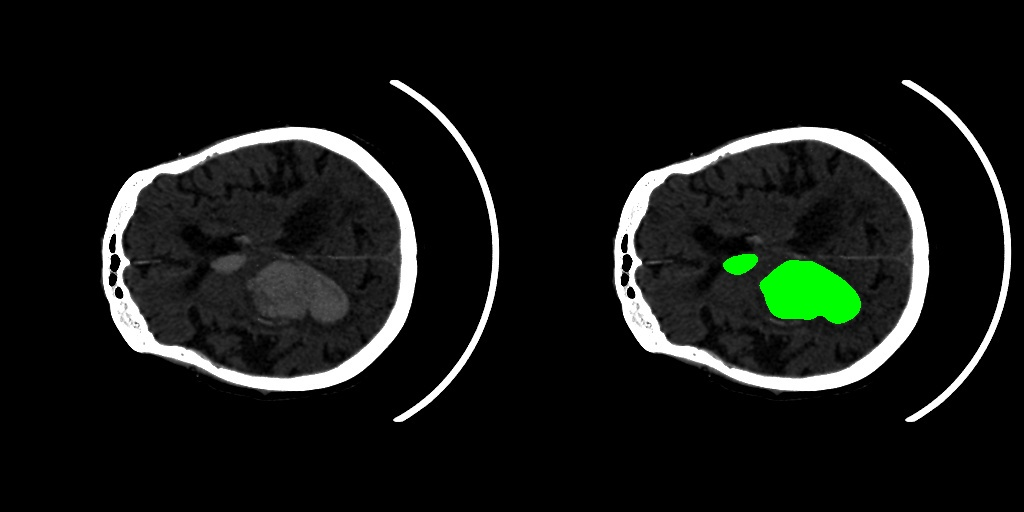

segmented badly:

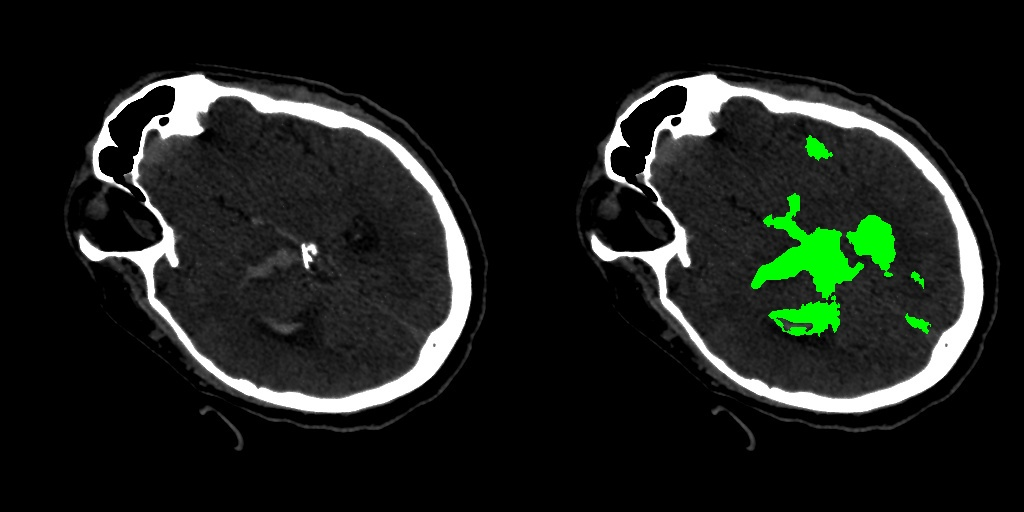

2. We tried to use the library for teaching without a teacher designed just for medical images https://github.com/ChenLiu-1996/UnsupervisedMedicalSeg . However, after the launch, we received an approximate estimate of the training time of 420 hours, which was more than we had left until the end of the competition, we had to give up.
3. ИI used color markup using OpenCV, additionally wrote an algorithm that finds the desired area of the head and "looks" only inside, the approach, although not perfect, worked and gave 0.64 on test data.
4. Using the algorithm from the previous step, all the available images were marked up, and Unet was simply trained with augmentation using them, this approach gave the best result.

Conclusion: Even for a relatively poorly marked up dataset using OpenCV, Unet learns well and eventually produces results much higher than the OpenCV markup, provided that the dataset is large enough.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
import cv2
import math

In [ ]:
!mkdir competition

In [ ]:
!mkdir competition/masks

In [ ]:
!mkdir tests

In [ ]:
!pwd

In [ ]:
main_path = '/kaggle/input/innopolis-global-ai-challenge-2023-ai4med/'

In [ ]:
## copy images for used in tests
import shutil
for ids in range(8000, 8025):
  shutil.copy(f'{main_path}competition/competition/00{ids}.jpg', f'/kaggle/working/tests/00{ids}.jpg')

In [ ]:
def mask_by_opencv(img_index, show=True):
    img_name = f'0{img_index}'
    while len(img_name) < 6:
        img_name = f'0{img_name}'

    print(img_name)
    image_path = f'{main_path}/competition/competition/{img_name}.jpg'
    size = (496, 496)
    # Load image and HSV color threshold
    image = cv2.imread(image_path)
    original = image.copy()

    original_resized = cv2.resize(original, size, interpolation = cv2.INTER_AREA)
    if show:
        plt.imshow(original)
        plt.show()

    image = cv2.cvtColor(original_resized, cv2.COLOR_BGR2HSV)

    black_lo=np.array([0,0,0])
    black_hi=np.array([0,0,1])

    # Mask image to only select black
    mask_black=cv2.inRange(image, black_lo, black_hi)

    white_lo=np.array([0,0,80])
    white_hi=np.array([0,0,255])

    # Mask image to only select white
    mask_white=cv2.inRange(image, white_lo, white_hi)

    mask_all = mask_white + mask_black

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(mask_white, cv2.MORPH_OPEN, kernel, iterations=1)
    dil = cv2.erode(opening, kernel, iterations=3)
    dil = cv2.dilate(dil, kernel, iterations=3)

    detected_white = cv2.bitwise_and(original_resized, original_resized, mask = mask_white)
    detected_white = cv2.cvtColor(detected_white, cv2.COLOR_RGB2GRAY)
    # blured = cv2.blur(detected, (9, 9))
    #blured = cv2.cvtColor(blured, cv2.COLOR_HSV2RGB)
    # blured = cv2.cvtColor(blured, cv2.COLOR_RGB2GRAY)
    if show:
        plt.imshow(detected_white)
        plt.show()

    contours_white, hierarchy_white = cv2.findContours(detected_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_counter_white = None
    max_counter_areas = 0
    counter_idx = 0
    for contour in contours_white:
        #dil = cv2.erode(contour, kernel, iterations=1)
        area = cv2.contourArea(contour)
        if area > 5000:
            if (area > max_counter_areas):
                max_counter_areas = area
                max_counter_white = contour

    # Remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opening = cv2.morphologyEx(mask_all, cv2.MORPH_OPEN, kernel, iterations=1)
    dil = cv2.dilate(opening, kernel, iterations=7)
    # Invert mask
    mask_inv = cv2.bitwise_not(dil)

    # Remove all by mask
    detected = cv2.bitwise_and(original_resized, original_resized, mask = mask_inv)
    blured = cv2.blur(detected, (9, 9))
    #blured = cv2.cvtColor(blured, cv2.COLOR_HSV2RGB)
    blured = cv2.cvtColor(blured, cv2.COLOR_RGB2GRAY)
    contours, hierarchy = cv2.findContours(blured, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    draw_counters = []
    main_counter_rect = []
    zeros = np.zeros(shape=(512,512), dtype=np.uint8)
    max_counter_index = 0
    max_counter_areas = 0
    counter_idx = 0
    for contour in contours:
        area = cv2.contourArea(contour)

        if area > 10000:
            if (area > max_counter_areas):
                max_counter_areas = area
                max_counter_index = counter_idx
            main_counter_rect.append(cv2.boundingRect(contour))
            draw_counters.append(contour)
            counter_idx += 1

    if len(main_counter_rect) == 0:
        final_zeros = np.zeros(shape=(512,512), dtype=np.uint8)
        cv2.imwrite(f'/kaggle/working/competition/masks/{img_name}.jpg', final_zeros)
        return final_zeros

    main_counter_rect = main_counter_rect[max_counter_index]
    main_center, main_axis, main_angle = cv2.fitEllipse(draw_counters[max_counter_index])
    main_center_white, main_axis_white, main_angle_white = cv2.fitEllipse(max_counter_white)
    ellipse = ((main_center[0] + 8, main_center[1] + 8), main_axis, main_angle)
    ellipse_white = ((main_center_white[0] + 8, main_center_white[1] + 8), main_axis_white, main_angle_white)



    eliplse_zeros = np.zeros(shape=(512,512), dtype=np.uint8)

    # finde intersaction area beetween two eliplse
    cv2.ellipse(eliplse_zeros, ellipse, (255,255,255), -1)
    cv2.ellipse(eliplse_zeros, ellipse_white, (0,0,0), -1)
    count_zero = np.count_nonzero(eliplse_zeros)
    # if intersection area more then 100 we will use external eliplse
    has_intersection = count_zero > 100

    # if show:
    #   plt.imshow(eliplse_zeros)
    #   plt.show()

    # cv2.drawContours(zeros, draw_counters, -1, (255,0,0), -1)
    if has_intersection:
        ellipse = ((main_center_white[0] + 8, main_center_white[1] + 8), (main_axis_white[0]-40, main_axis_white[1]-40), main_angle_white)

    cv2.ellipse(zeros, ellipse, (255,255,255), -1)
    if show:
        plt.imshow(zeros)
        plt.show()
    detected = cv2.bitwise_and(original, original, mask = zeros)
    if show:
        plt.imshow(detected)
        plt.show()

    ## find by color
    lower = np.array([0, 0, 40], dtype="uint8")
    upper = np.array([0, 0, 90], dtype="uint8")
    lower2 = np.array([0, 0, 50], dtype="uint8")
    upper2 = np.array([0, 0, 80], dtype="uint8")
    image = cv2.cvtColor(detected, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(image, lower2, upper2)
    mask1 = cv2.blur(mask1, (2, 2))

    mask = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=3)

    if show:
        plt.imshow(mask)
        plt.show()

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area = 0
    arreas = []
    draw_counters = []
    x_y = []
    max = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > 50:
            # draw_counters.append(c)
            # x, y, w, h = cv2.boundingRect(c)
            center, axis, angle = cv2.fitEllipse(c)
            x_y.append(center)

    contours, hierarchy = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        area = cv2.contourArea(c)
        if area > 50:
            is_add = False
            center, axis, angle = cv2.fitEllipse(c)
            for main_center in x_y:
                divX = math.fabs(1 - main_center[0] / center[0])
                divY = math.fabs(1 - main_center[1] / center[1])
                # print(f'x: {divX} y: {divY}')
                if (divX < 0.1) and (divY < 0.1):
                    is_add = True

            if is_add:
                blured = cv2.blur(c, (3, 3))
                draw_counters.append(blured)

    draw_original = original.copy()
    cv2.drawContours(draw_original, draw_counters, -1, (255,0,0), -1)
    if show:
        plt.imshow(draw_original)
        plt.show()


    final_zeros = np.zeros(shape=(512,512), dtype=np.uint8)

    cv2.drawContours(final_zeros, draw_counters, -1, (255,255,255), -1)
    # vis = np.concatenate((original, draw_original), axis=1)
    # cv2.imwrite(f'/content/out/{img_name}.jpg', vis)

    cv2.imwrite(f'/kaggle/working/competition/masks/{img_name}.jpg', final_zeros)
    return final_zeros

Examples of markup using OpenCV

000000


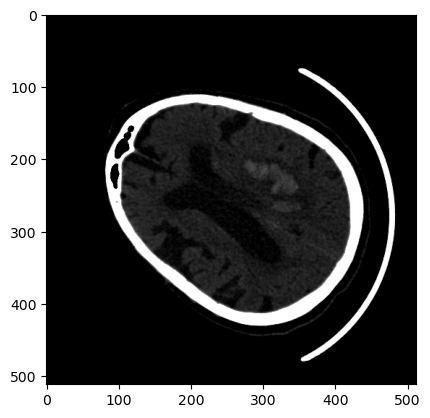

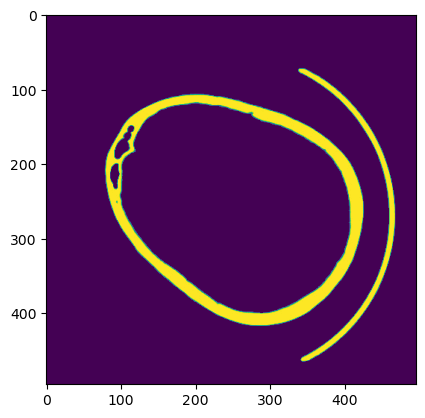

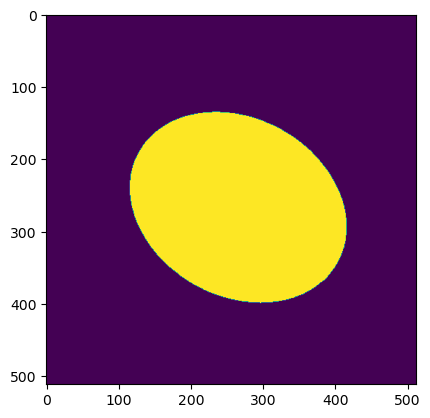

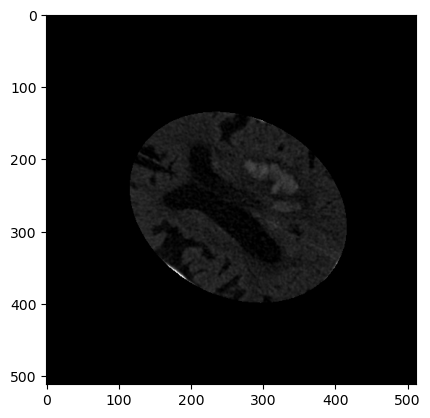

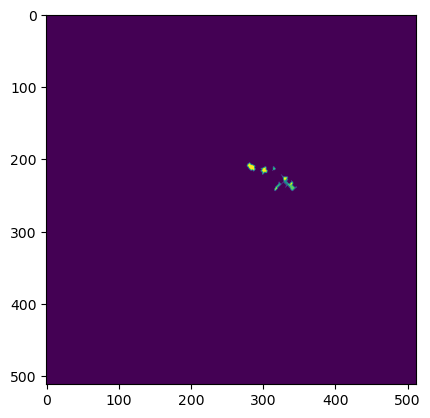

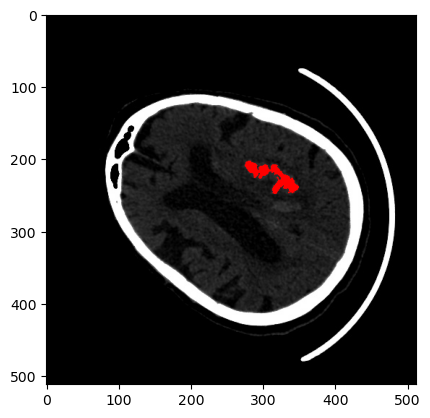

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [83]:
mask_by_opencv(0, True)

008001


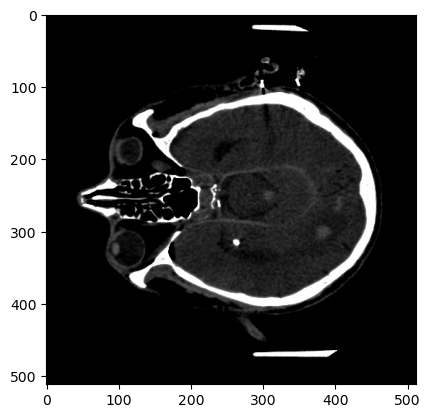

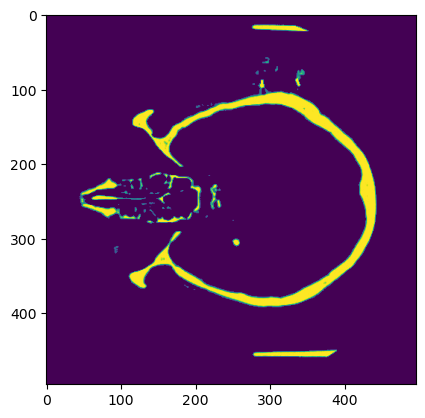

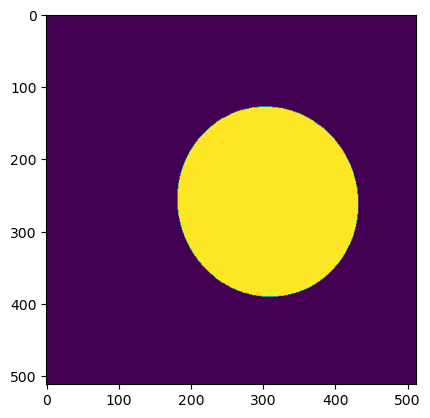

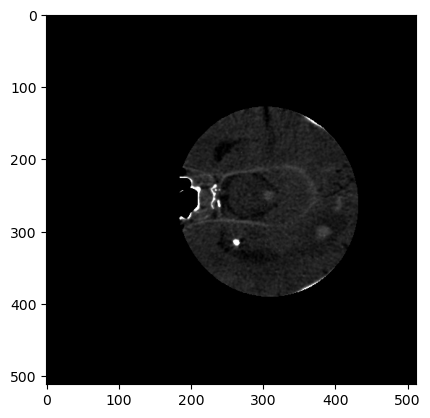

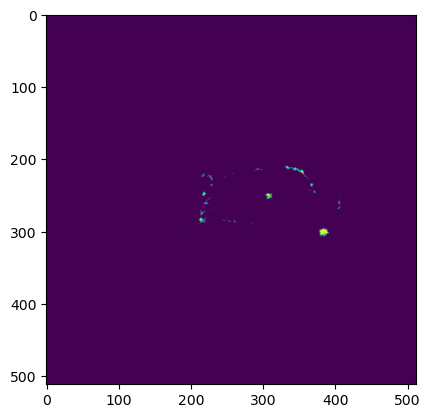

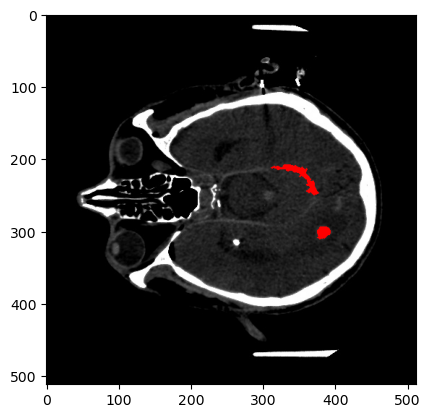

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [84]:
mask_by_opencv(8001, True)

It can be seen that by color, areas that are not hemorrhages, but are some kind of structures in the brain, also fall into the marking

### Processing all images use OpenCV algorithm for getting masks

In [ ]:
for idx in range(0, 26726):
  mask_img = mask_by_opencv(idx, False)

## Install libraries for segmentations

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
!pip install pytorch_lightning

## Loader

In [86]:
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from segmentation_models_pytorch.utils.metrics import IoU

from pathlib import Path


train_image_path = Path('/kaggle/input/innopolis-global-ai-challenge-2023-ai4med/competition/competition')
train_mask_path = Path('/kaggle/working/competition/masks')

test_path = Path('/kaggle/working/tests')


In [87]:
ALL_IMAGES = sorted(train_image_path.glob("*.jpg"))
len(ALL_IMAGES)

26726

In [88]:
ALL_MASKS = sorted(train_mask_path.glob("*.jpg"))
len(ALL_MASKS)

26726

In [89]:
ALL_TESTS = sorted(test_path.glob("*.jpg"))
len(ALL_TESTS)

25

In [90]:
import random
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, List, Tuple

import os
import torch
from PIL import Image


def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path).convert("RGB")) # utils.imread(image_path)
    mask = np.array(Image.open(masks[index]).convert("L"), dtype=np.float32) # utils.imread(masks[index])
    mask /= 255
    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

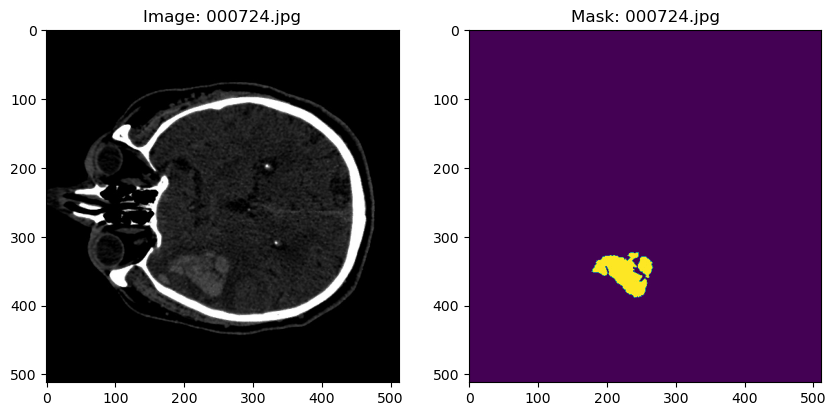

In [91]:
show_random(ALL_IMAGES, ALL_MASKS)

## Augmentation

In [ ]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2


def pre_transforms(image_size=512):
    return [albu.Resize(image_size, image_size, p=1)]

def hard_transforms():
    result = [
      # albu.Rotate(limit=35, p=1.0),
      # albu.HorizontalFlip(p=0.5),
      # albu.VerticalFlip(p=0.1),
      albu.RandomRotate90(),
      #albu.RandomCrop(200, 100),
      albu.HorizontalFlip(),
      albu.VerticalFlip(),
      # albu.Blur(blur_limit=1),
      # albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      # albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result


def resize_transforms(image_size=512):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [
            albu.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0
            ),
            ToTensorV2()
    ]

def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [ ]:
train_transforms = compose([
    pre_transforms(),
    hard_transforms(),
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

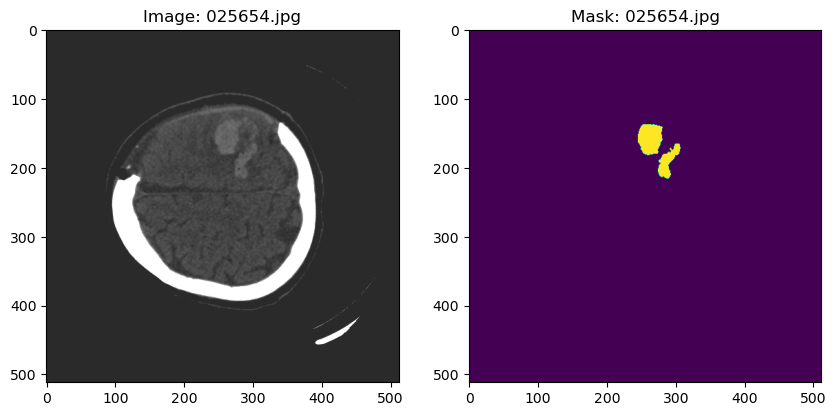

In [92]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

In [93]:
from typing import List
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = np.array(Image.open(image_path).convert("RGB")) #utils.imread(image_path)

        # image = np.moveaxis(image, -1, 0)

        result = {"image": image}

        if self.masks is not None:
            mask = np.array(Image.open(self.masks[idx]).convert("L"), dtype=np.float32) #utils.imread(self.masks[idx], grayscale = True)
            mask /= 255
            result["mask"] = mask
            
        if self.transforms is not None:
            result = self.transforms(**result)

        result["filename"] = image_path.name
        if self.masks is not None:
          result["mask"] = np.expand_dims(result["mask"], axis = 0)

        return result

In [ ]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int = 42,
    valid_size: float = 0.1,
    batch_size: int = 4,
    num_workers: int = 2,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [ ]:
batch_size =16

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

In [ ]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_test_loader(
    images: List[Path],
    batch_size: int = 15,
    num_workers: int = 2,
    transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    np_images = np.array(images)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images.tolist(),
      transforms = transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    return train_loader

In [ ]:
test_loader = get_test_loader(
    images=ALL_TESTS,
    transforms_fn=valid_transforms,
    batch_size=1
)

## Utils

In [ ]:
from typing import Optional, List, Tuple, Union

def get_stats(
    output: Union[torch.LongTensor, torch.FloatTensor],
    target: torch.LongTensor,
    mode: str,
    ignore_index: Optional[int] = None,
    threshold: Optional[Union[float, List[float]]] = None,
    num_classes: Optional[int] = None,
) -> Tuple[torch.LongTensor]:
    """Compute true positive, false positive, false negative, true negative 'pixels'
    for each image and each class.
    Args:
        output (Union[torch.LongTensor, torch.FloatTensor]): Model output with following
            shapes and types depending on the specified ``mode``:
            'binary'
                shape (N, 1, ...) and ``torch.LongTensor`` or ``torch.FloatTensor``
            'multilabel'
                shape (N, C, ...) and ``torch.LongTensor`` or ``torch.FloatTensor``
            'multiclass'
                shape (N, ...) and ``torch.LongTensor``
        target (torch.LongTensor): Targets with following shapes depending on the specified ``mode``:
            'binary'
                shape (N, 1, ...)
            'multilabel'
                shape (N, C, ...)
            'multiclass'
                shape (N, ...)
        mode (str): One of ``'binary'`` | ``'multilabel'`` | ``'multiclass'``
        ignore_index (Optional[int]): Label to ignore on for metric computation.
            **Not** supproted for ``'binary'`` and ``'multilabel'`` modes.  Defaults to None.
        threshold (Optional[float, List[float]]): Binarization threshold for
            ``output`` in case of ``'binary'`` or ``'multilabel'`` modes. Defaults to None.
        num_classes (Optional[int]): Number of classes, necessary attribute
            only for ``'multiclass'`` mode. Class values should be in range 0..(num_classes - 1).
            If ``ignore_index`` is specified it should be outside the classes range, e.g. ``-1`` or
            ``255``.
    Raises:
        ValueError: in case of misconfiguration.
    Returns:
        Tuple[torch.LongTensor]: true_positive, false_positive, false_negative,
            true_negative tensors (N, C) shape each.
    """

    if torch.is_floating_point(target):
        raise ValueError(f"Target should be one of the integer types, got {target.dtype}.")

    if torch.is_floating_point(output) and threshold is None:
        raise ValueError(
            f"Output should be one of the integer types if ``threshold`` is not None, got {output.dtype}."
        )

    if torch.is_floating_point(output) and mode == "multiclass":
        raise ValueError(f"For ``multiclass`` mode ``target`` should be one of the integer types, got {output.dtype}.")

    if mode not in {"binary", "multiclass", "multilabel"}:
        raise ValueError(f"``mode`` should be in ['binary', 'multiclass', 'multilabel'], got mode={mode}.")

    if mode == "multiclass" and threshold is not None:
        raise ValueError("``threshold`` parameter does not supported for this 'multiclass' mode")

    if output.shape != target.shape:
        raise ValueError(
            "Dimensions should match, but ``output`` shape is not equal to ``target`` "
            + f"shape, {output.shape} != {target.shape}"
        )

    if mode != "multiclass" and ignore_index is not None:
        raise ValueError(f"``ignore_index`` parameter is not supproted for '{mode}' mode")

    if mode == "multiclass" and num_classes is None:
        raise ValueError("``num_classes`` attribute should be not ``None`` for 'multiclass' mode.")

    if ignore_index is not None and 0 <= ignore_index <= num_classes - 1:
        raise ValueError(
            f"``ignore_index`` should be outside the class values range, but got class values in range "
            f"0..{num_classes - 1} and ``ignore_index={ignore_index}``. Hint: if you have ``ignore_index = 0``"
            f"consirder subtracting ``1`` from your target and model output to make ``ignore_index = -1``"
            f"and relevant class values started from ``0``."
        )

    if mode == "multiclass":
        tp, fp, fn, tn = _get_stats_multiclass(output, target, num_classes, ignore_index)
    else:
        if threshold is not None:
            output = torch.where(output >= threshold, 1, 0)
            target = torch.where(target >= threshold, 1, 0)
        tp, fp, fn, tn = _get_stats_multilabel(output, target)

    return tp, fp, fn, tn


@torch.no_grad()
def _get_stats_multiclass(
    output: torch.LongTensor,
    target: torch.LongTensor,
    num_classes: int,
    ignore_index: Optional[int],
) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor, torch.LongTensor]:

    batch_size, *dims = output.shape
    num_elements = torch.prod(torch.tensor(dims)).long()

    if ignore_index is not None:
        ignore = target == ignore_index
        output = torch.where(ignore, -1, output)
        target = torch.where(ignore, -1, target)
        ignore_per_sample = ignore.view(batch_size, -1).sum(1)

    tp_count = torch.zeros(batch_size, num_classes, dtype=torch.long)
    fp_count = torch.zeros(batch_size, num_classes, dtype=torch.long)
    fn_count = torch.zeros(batch_size, num_classes, dtype=torch.long)
    tn_count = torch.zeros(batch_size, num_classes, dtype=torch.long)

    for i in range(batch_size):
        target_i = target[i]
        output_i = output[i]
        mask = output_i == target_i
        matched = torch.where(mask, target_i, -1)
        tp = torch.histc(matched.float(), bins=num_classes, min=0, max=num_classes - 1)
        fp = torch.histc(output_i.float(), bins=num_classes, min=0, max=num_classes - 1) - tp
        fn = torch.histc(target_i.float(), bins=num_classes, min=0, max=num_classes - 1) - tp
        tn = num_elements - tp - fp - fn
        if ignore_index is not None:
            tn = tn - ignore_per_sample[i]
        tp_count[i] = tp.long()
        fp_count[i] = fp.long()
        fn_count[i] = fn.long()
        tn_count[i] = tn.long()

    return tp_count, fp_count, fn_count, tn_count


@torch.no_grad()
def _get_stats_multilabel(
    output: torch.LongTensor,
    target: torch.LongTensor,
) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor, torch.LongTensor]:

    batch_size, num_classes, *dims = target.shape
    output = output.view(batch_size, num_classes, -1)
    target = target.view(batch_size, num_classes, -1)

    tp = (output * target).sum(2)
    fp = output.sum(2) - tp
    fn = target.sum(2) - tp
    tn = torch.prod(torch.tensor(dims)) - (tp + fp + fn)

    return tp, fp, fn, tn

def _handle_zero_division(x, zero_division):
    nans = torch.isnan(x)
    if torch.any(nans) and zero_division == "warn":
        print("Zero division in metric calculation!")
    value = zero_division if zero_division is not "warn" else 0
    value = torch.tensor(value, dtype=x.dtype).to(x.device)
    x = torch.where(nans, value, x)
    return x

def _iou_score(tp, fp, fn, tn):
    return tp / (tp + fp + fn)



def _compute_metric(metric_fn, tp, fp, fn, tn, reduction: Optional[str] = None,
        class_weights: Optional[List[float]] = None, zero_division="warn", **metric_kwargs) -> float:

    if class_weights is None and reduction is not None and "weighted" in reduction:
        raise ValueError(f"Class weights should be provided for `{reduction}` reduction")

    class_weights = class_weights if class_weights is not None else 1.
    class_weights = torch.tensor(class_weights).to(tp.device)
    class_weights = class_weights / class_weights.sum()

    if reduction == "micro":
        tp = tp.sum()
        fp = fp.sum()
        fn = fn.sum()
        tn = tn.sum()
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)

    elif reduction == "macro" or reduction == "weighted":
        tp = tp.sum(0)
        fp = fp.sum(0)
        fn = fn.sum(0)
        tn = tn.sum(0)
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = (score * class_weights).mean()

    elif reduction == "micro-imagewise":
        tp = tp.sum(1)
        fp = fp.sum(1)
        fn = fn.sum(1)
        tn = tn.sum(1)
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = score.mean()

    elif reduction == "macro-imagewise" or reduction == "weighted-imagewise":
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = (score.mean(0) * class_weights).mean()

    elif reduction == "none" or reduction is None:
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)

    else:
        raise ValueError("`reduction` should be in " + \
            "[micro, macro, weighted, micro-imagewise, macro-imagesize, weighted-imagewise, none, None]")

    return score

def iou_score(tp, fp, fn, tn, reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None, zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """IoU score or Jaccard index"""
    return _compute_metric(
        _iou_score,
        tp, fp, fn, tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )

## Model

In [ ]:
class SegmenationModel(pl.LightningModule):

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.Unet(encoder_name, encoder_weights='imagenet', in_channels=in_channels, classes=1)

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]
        #print(image.shape)
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        self.log(f"{stage}_dataset_iou", dataset_iou) 

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    # def on_train_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    # def on_validation_epoch_end(self, outputs):
    #     return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = SegmenationModel("mobilenet_v2", in_channels=3, out_classes=1)

### Train process

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    # callbacks=[checkpoint_callback]
)

trainer.fit(
    model,
    train_dataloaders=loaders["train"],
    val_dataloaders=loaders["valid"],
)

## Load saved weight from google disk

In [ ]:
!pip install gdown

In [ ]:
import gdown 

In [ ]:
gdown.download('https://drive.google.com/uc?id=1jTAx6SkAzYV3TiSVFvcU2h_eDsAWp3JT', 'epoch=9-step=14960.ckpt', quiet=False)

## Create model from saved weights

In [78]:
new_model = SegmenationModel.load_from_checkpoint(encoder_name="mobilenet_v2", in_channels=3, out_classes=1, checkpoint_path="lightning_logs/version_0/checkpoints/epoch=9-step=15030.ckpt")

In [80]:
import PIL

def save_predictions_as_plot_test(
    loader, model, device="cpu", save = False
):
    model.eval()
    for idx, data in enumerate(loader):
        origin_x = data['image']
        x = data['image']
        print(x.shape)
        filename = data["filename"][0]
        #filename_jpg = filename.replace('.png', '.jpg')
        print(filename)

        im_origin = Image.open('/kaggle/working/tests/' + filename)
        width, height = im_origin.size
        print(width, height)
        x = x.to(device=device)
        print('to_device')
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()        
            preds = preds.to('cpu')
            np_preds = preds[0].numpy().T[:,:,0]
            np_preds[np_preds > 0.5] = 255
            np_preds[np_preds < 0.5] = 0
            show_examples(name="", image=origin_x[0].T, mask=np_preds)
            if save:
                im1 = Image.fromarray(np_preds)
                im1 = im1.convert('RGB')
                im1 = im1.rotate(270, PIL.Image.NEAREST, expand = 1)
                im1 = im1.transpose(PIL.Image.FLIP_LEFT_RIGHT)
                im1.save(r'/kaggle/working/result/' + filename)
        torch.cuda.empty_cache()

In [ ]:
!mkdir result

torch.Size([1, 3, 512, 512])
008000.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008001.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008002.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008003.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008004.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008005.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008006.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008007.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008008.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008009.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008010.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008011.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008012.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008013.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008014.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008015.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008016.jpg
512 512
to_device
torch.Size([1,

/tmp/ipykernel_29/485583769.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 14))


torch.Size([1, 3, 512, 512])
008022.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008023.jpg
512 512
to_device
torch.Size([1, 3, 512, 512])
008024.jpg
512 512
to_device


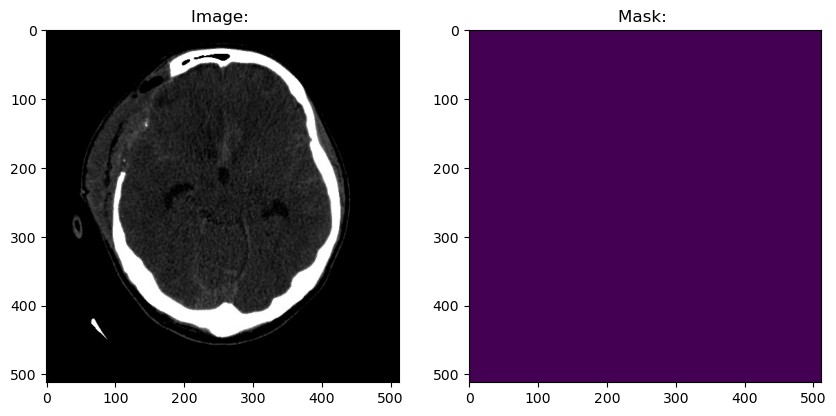

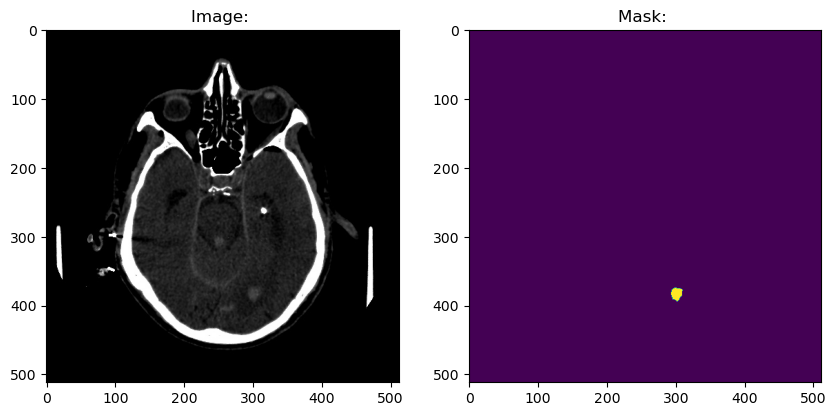

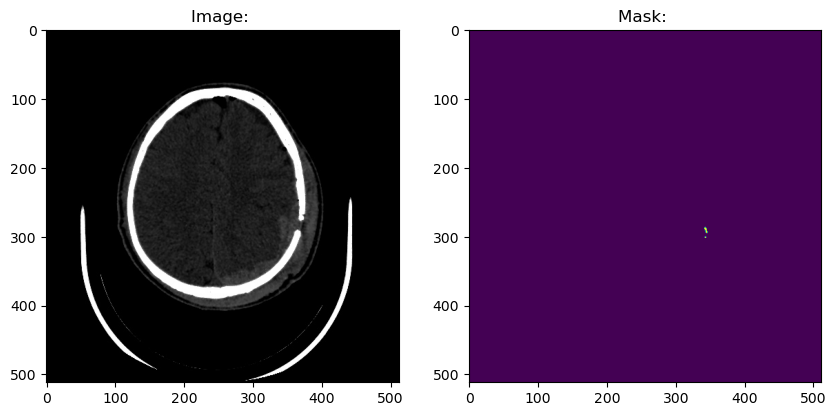

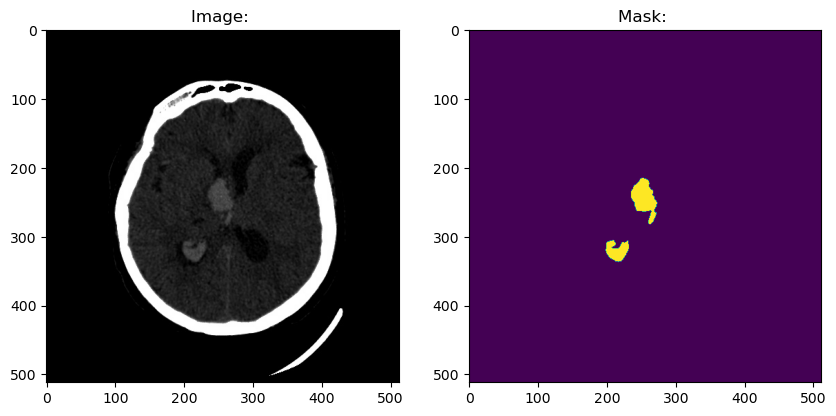

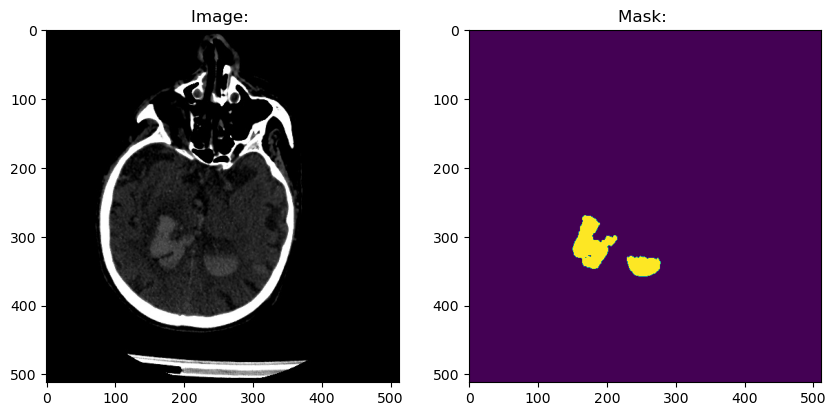

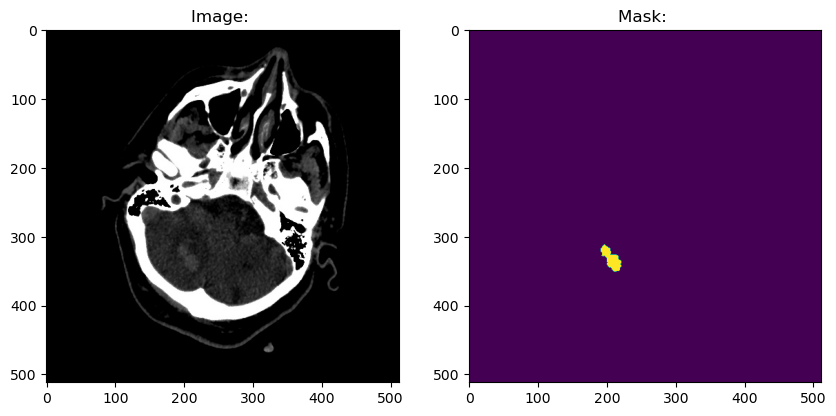

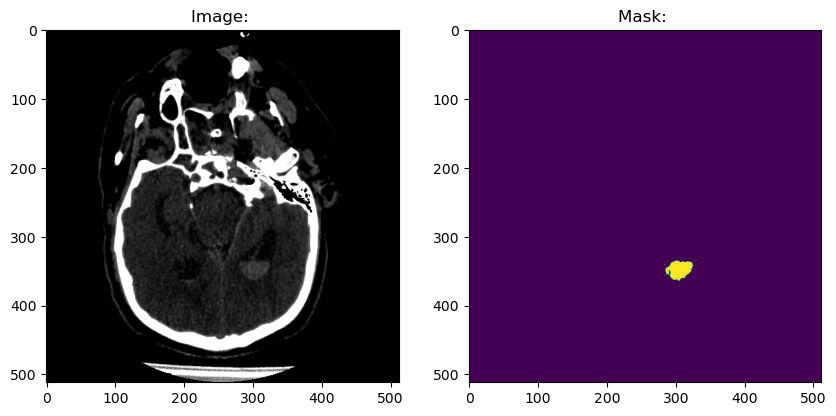

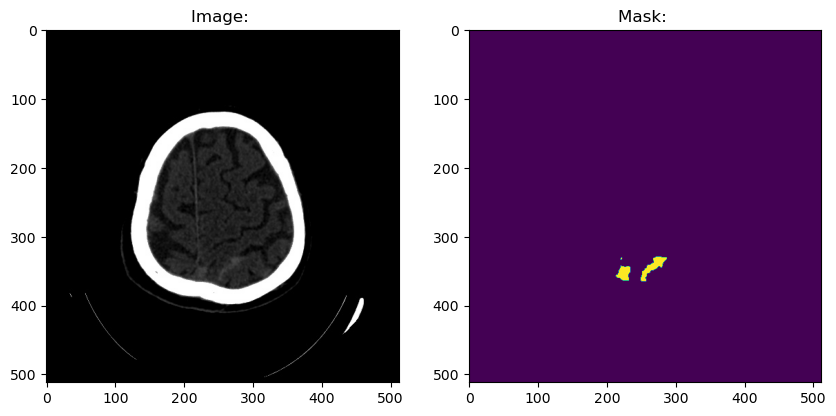

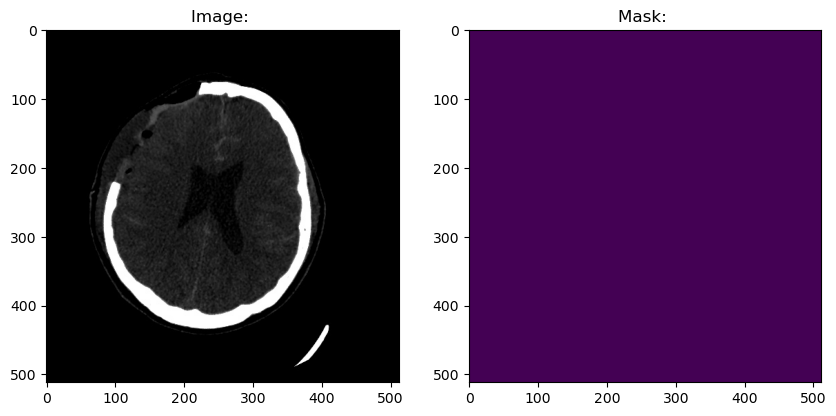

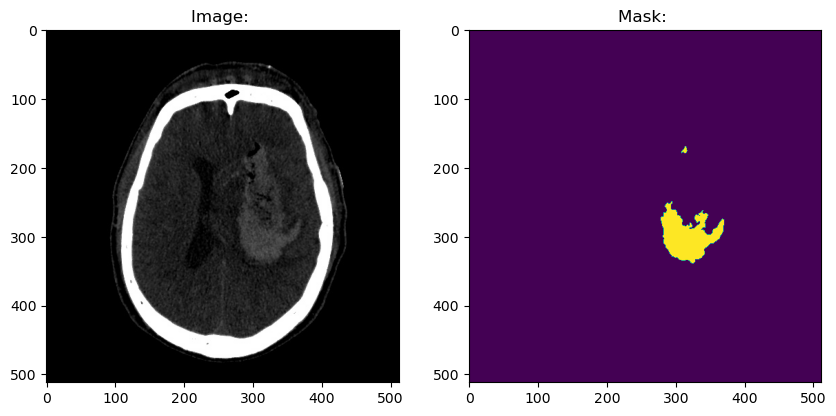

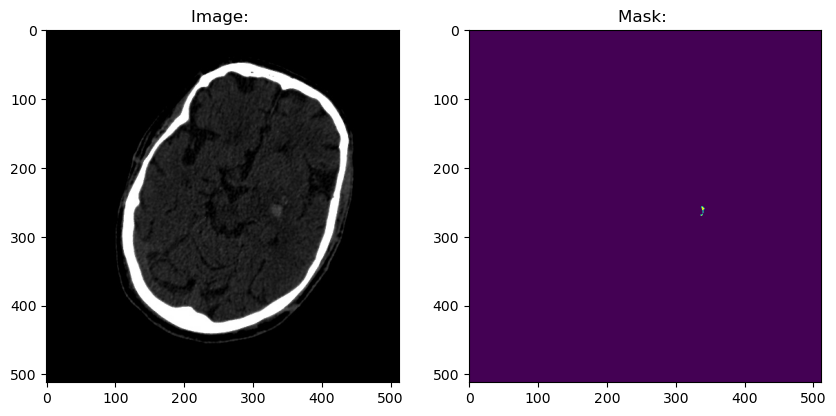

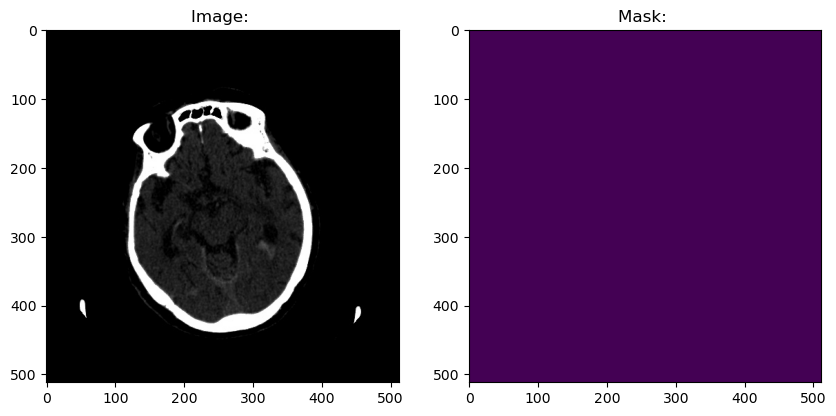

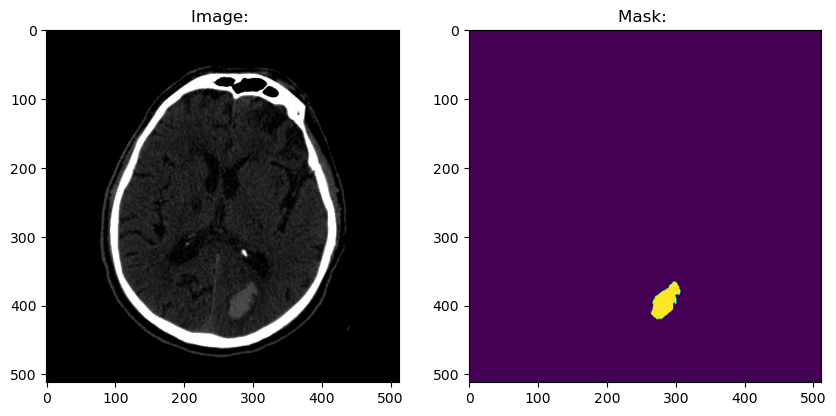

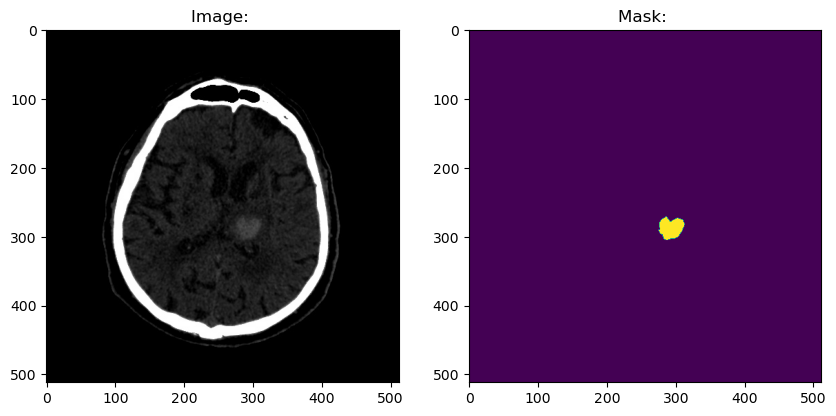

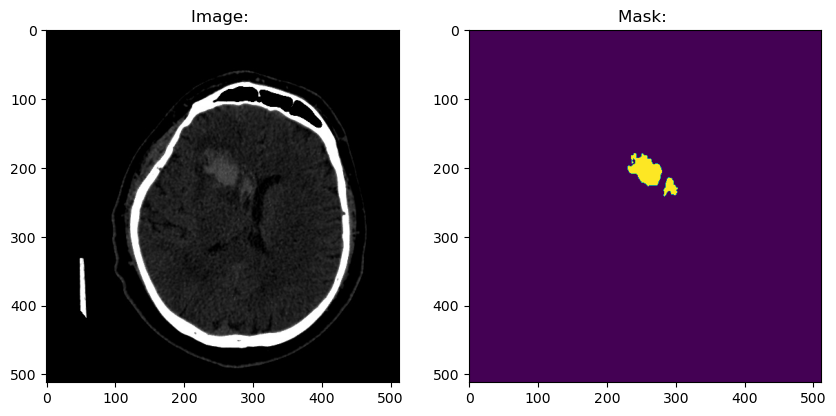

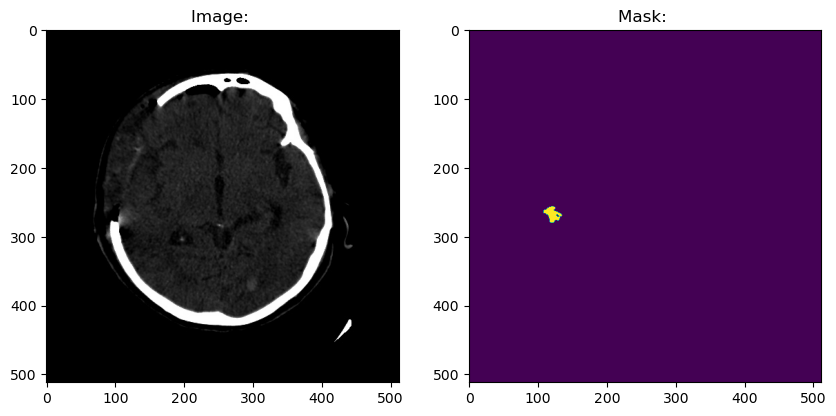

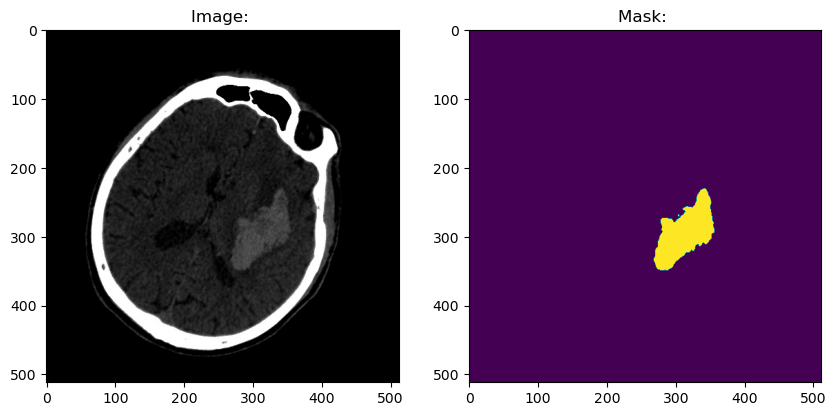

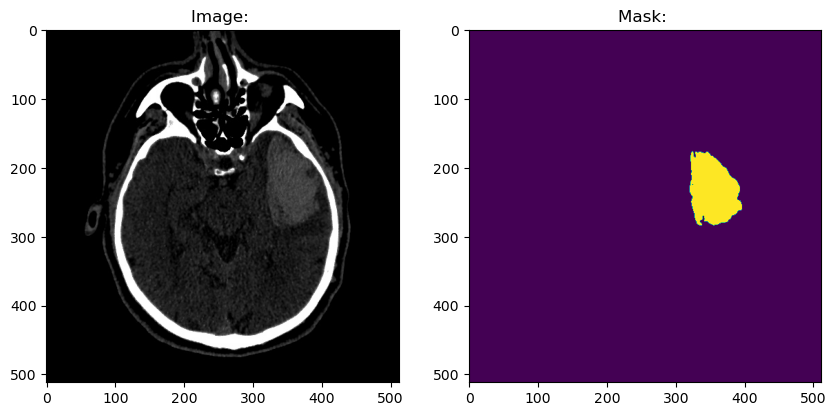

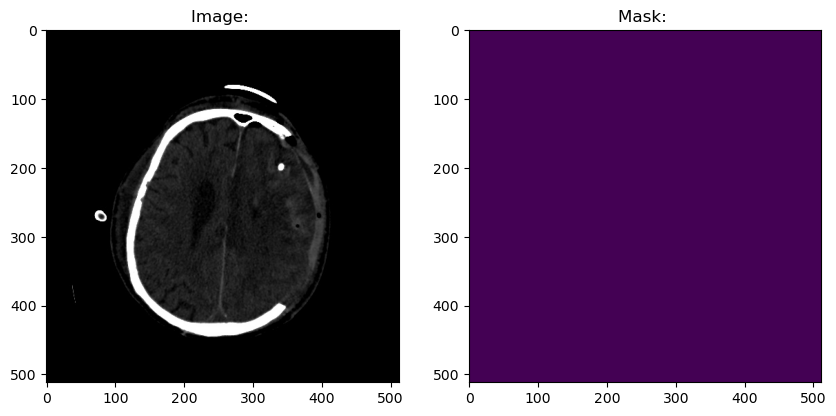

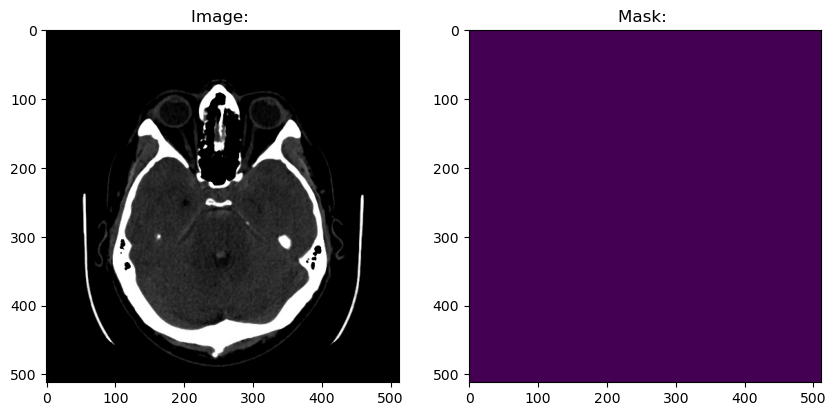

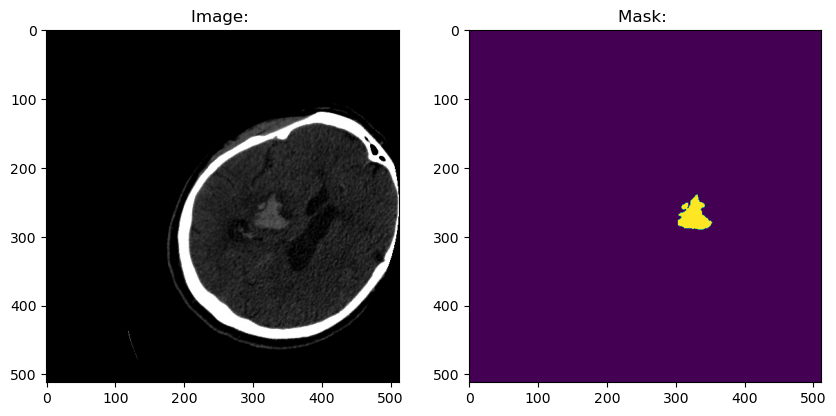

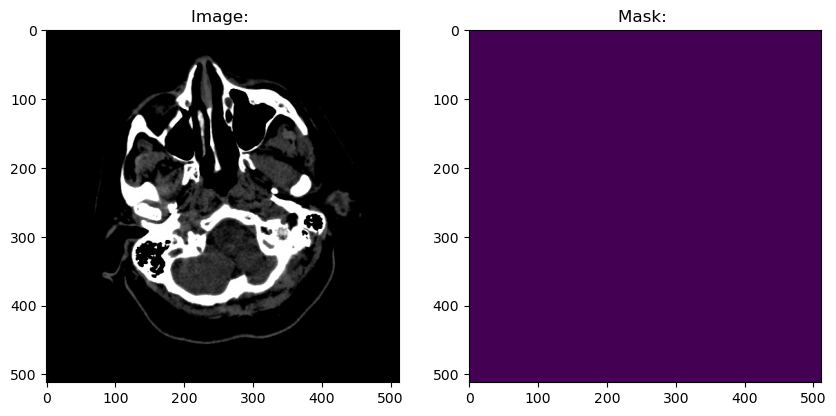

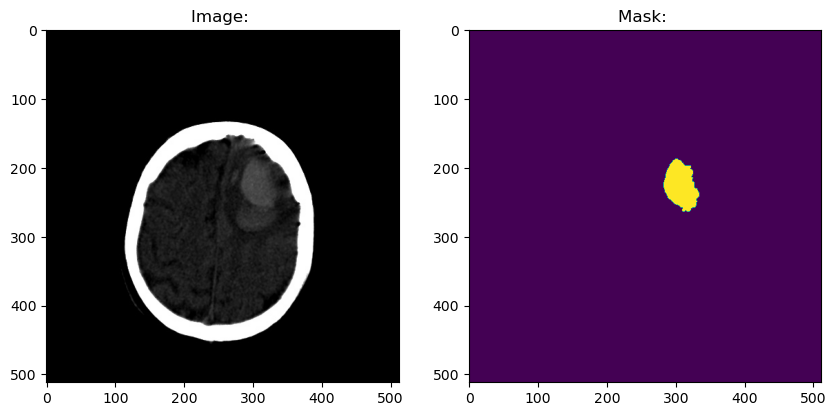

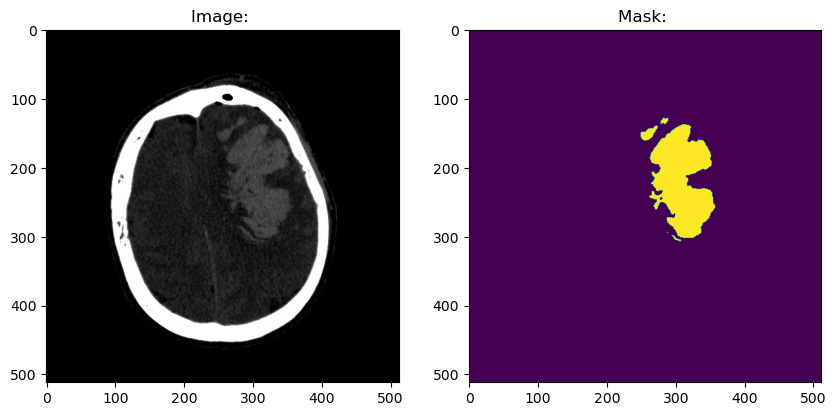

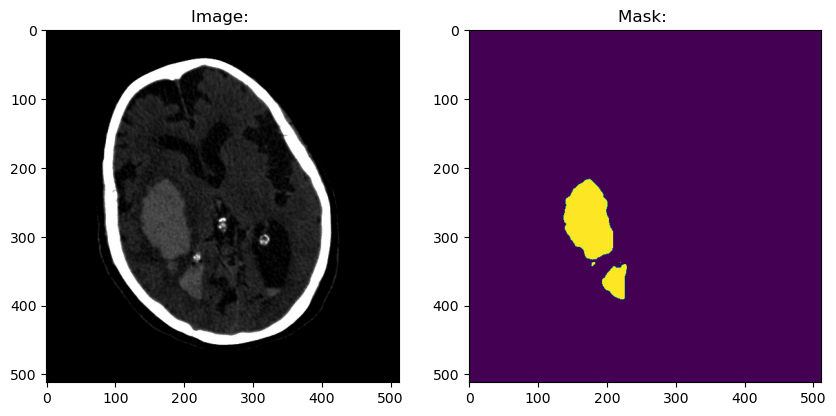

In [81]:
save_predictions_as_plot_test(
    test_loader, new_model, device="cuda", save = True
)

## Compare with OpenCV initial masks

In [ ]:
!ls /kaggle/working/competition

/tmp/ipykernel_29/485583769.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 14))


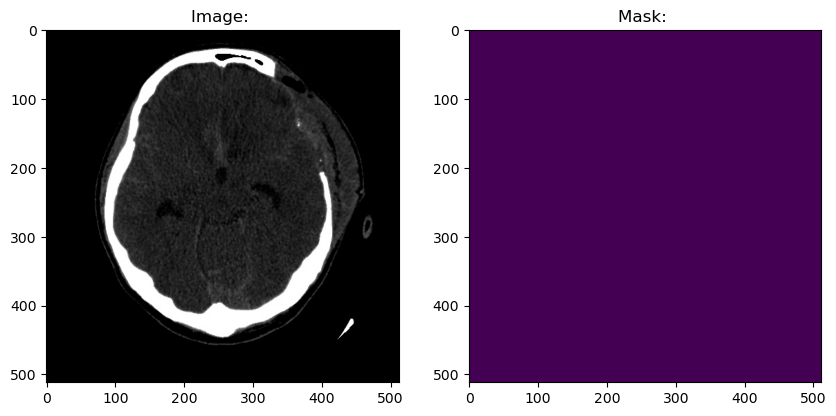

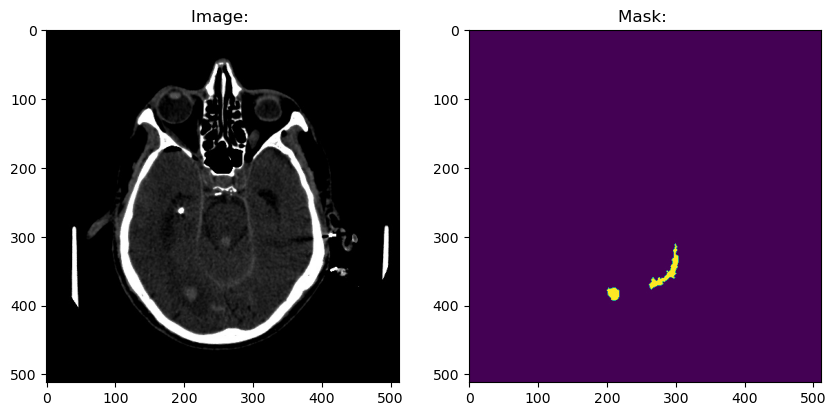

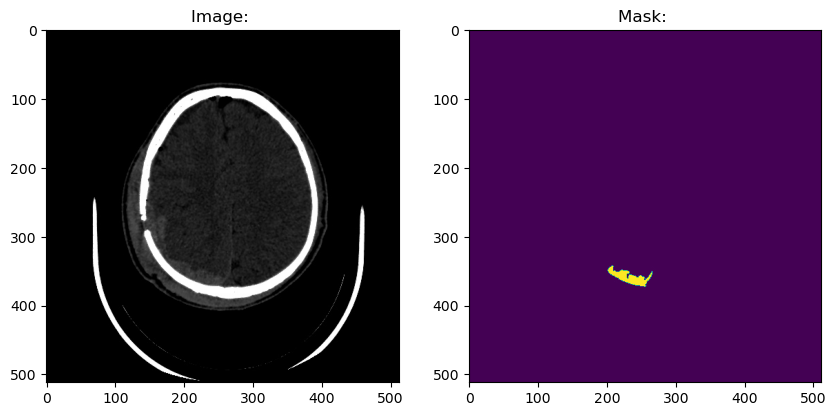

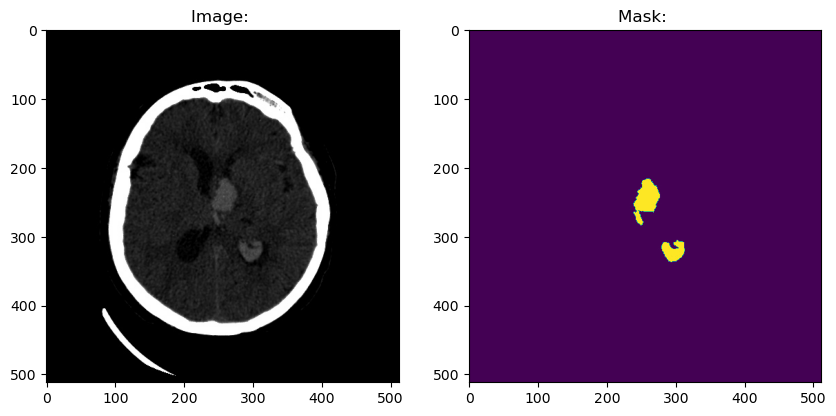

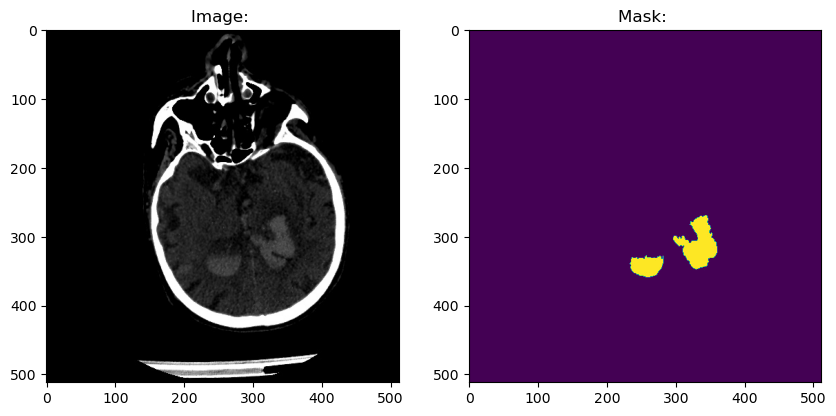

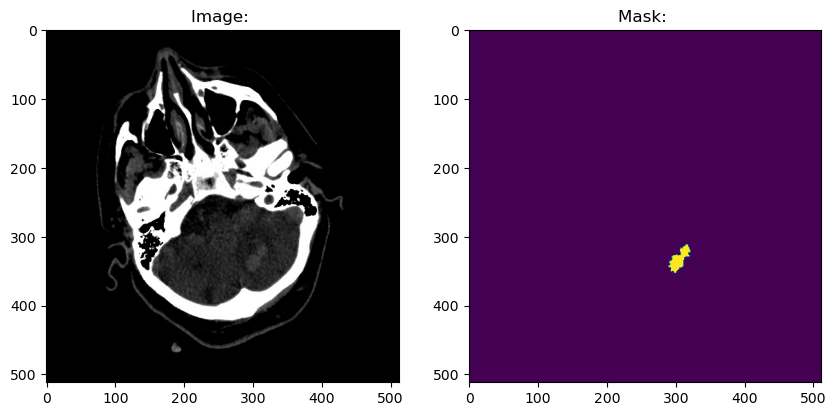

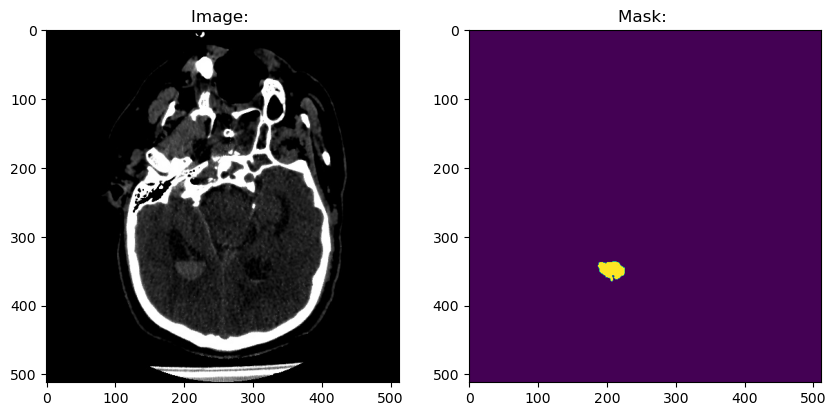

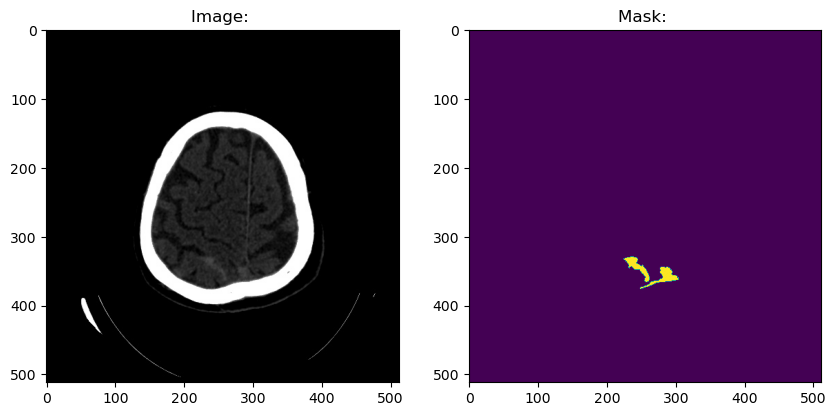

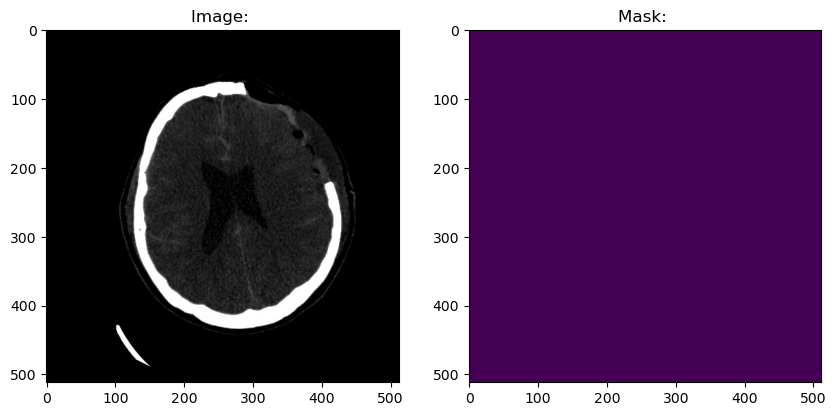

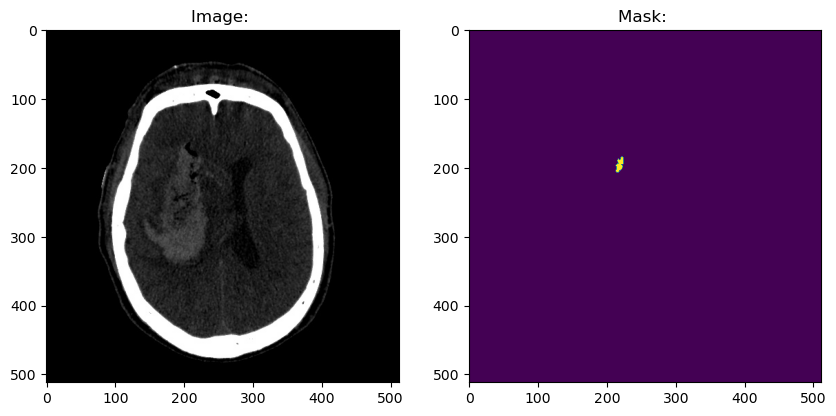

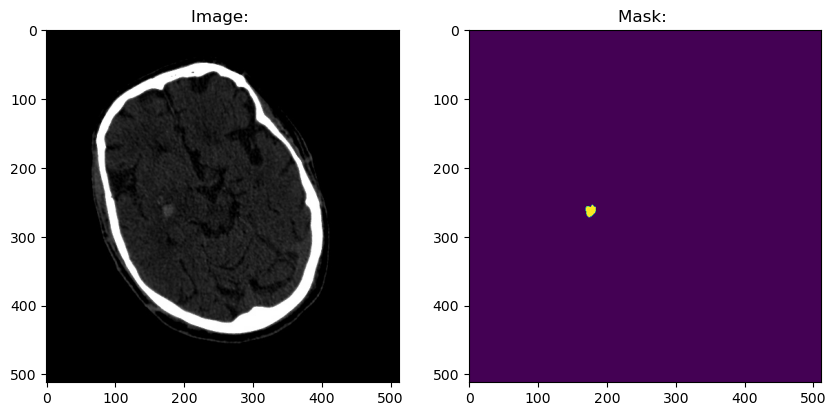

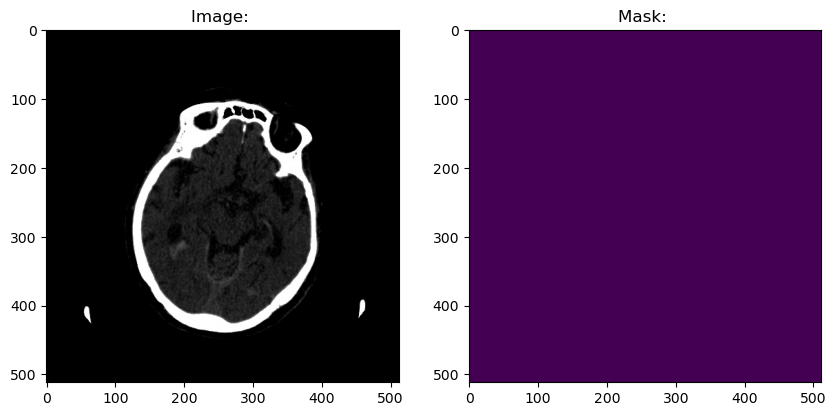

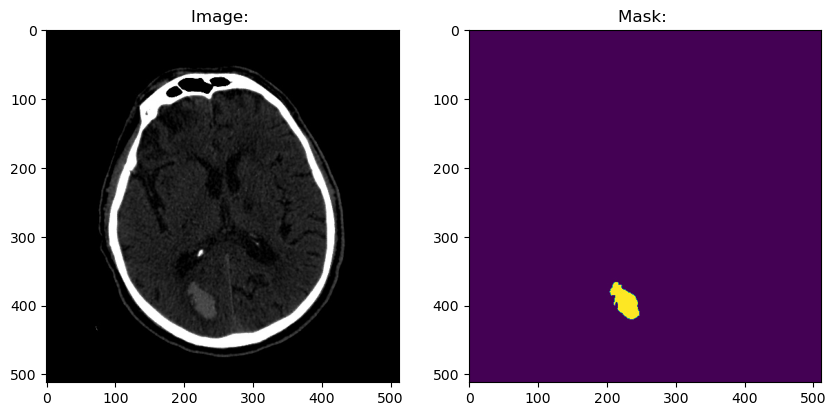

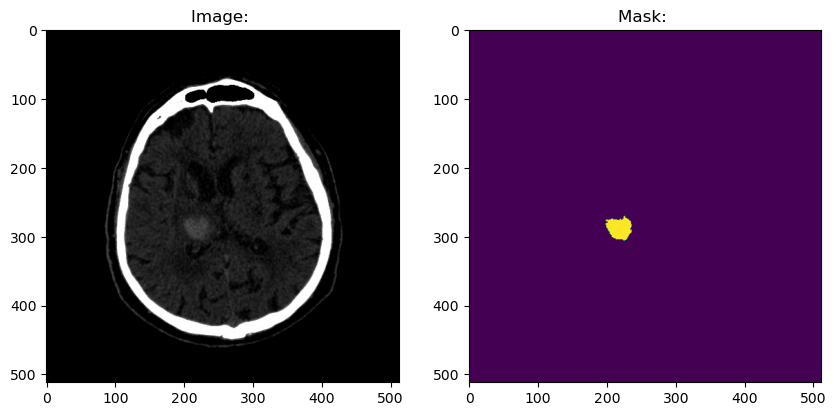

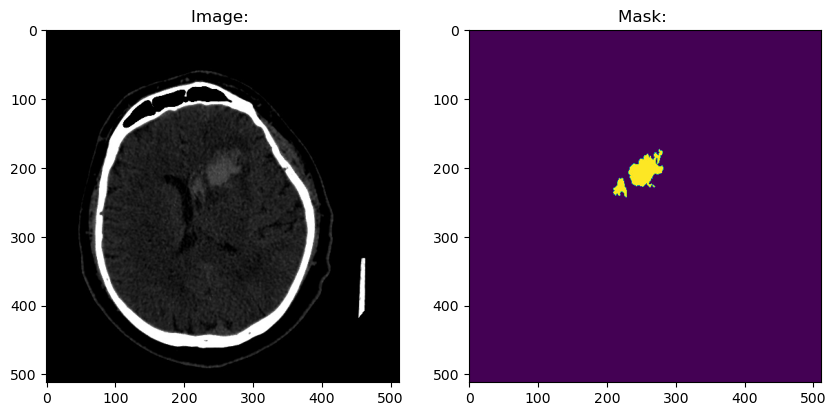

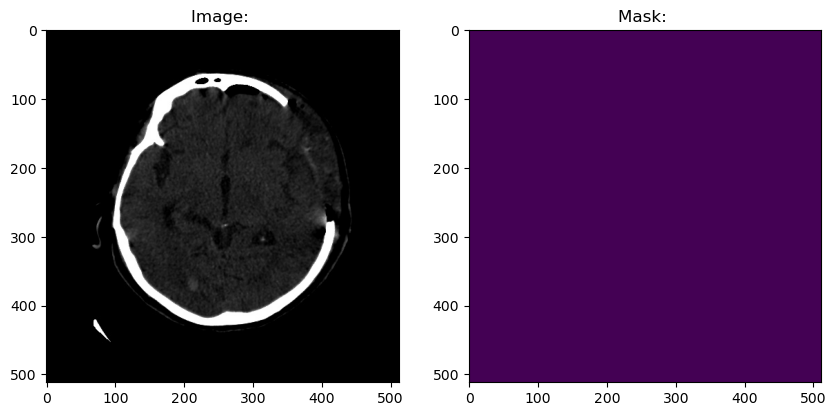

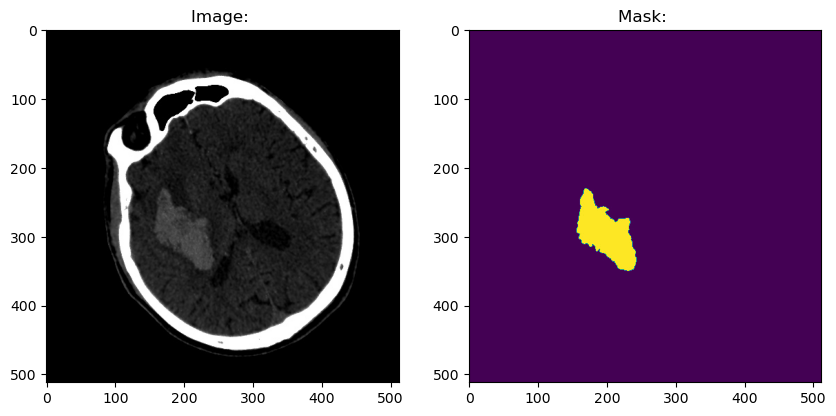

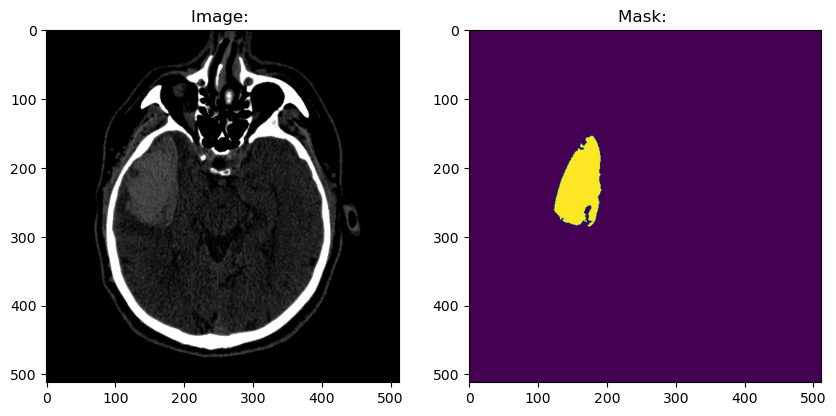

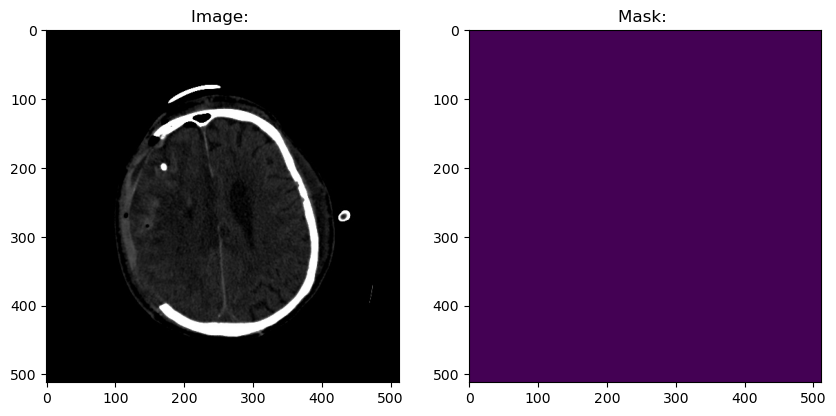

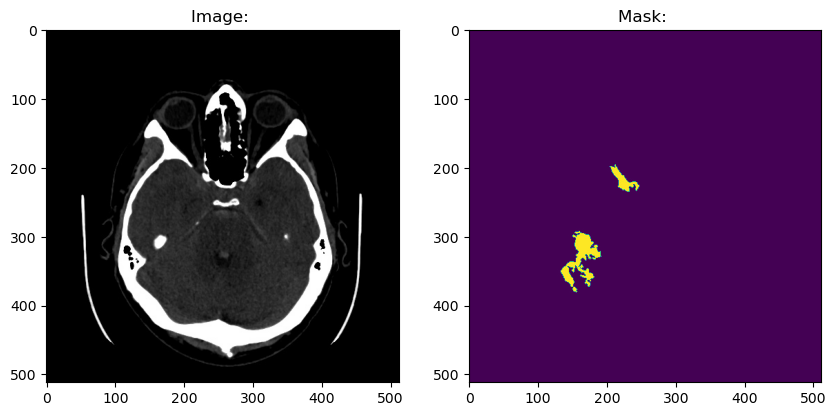

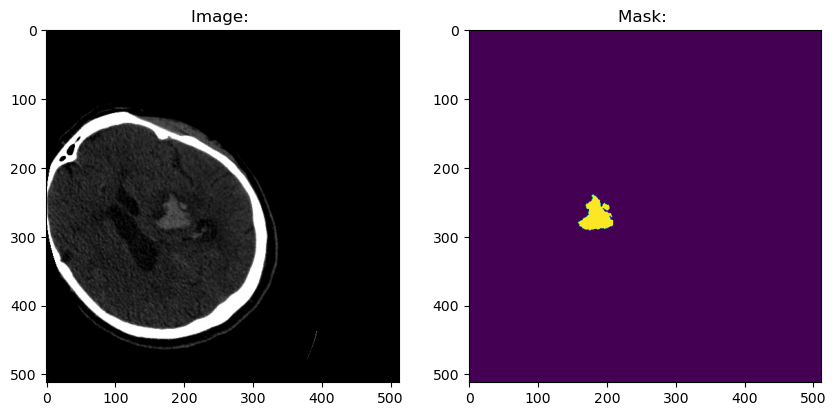

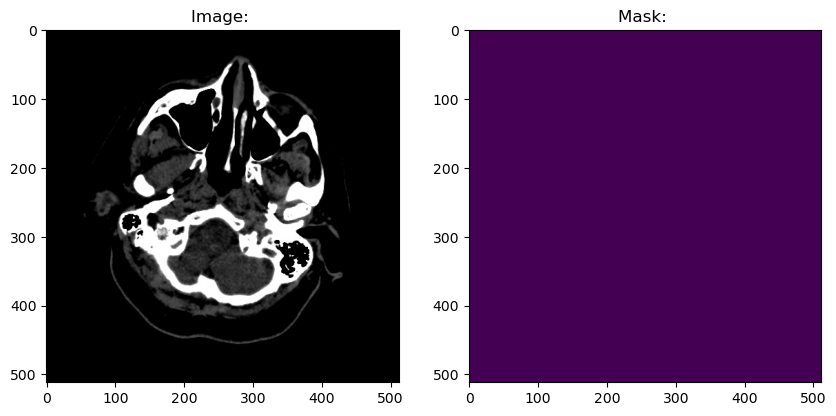

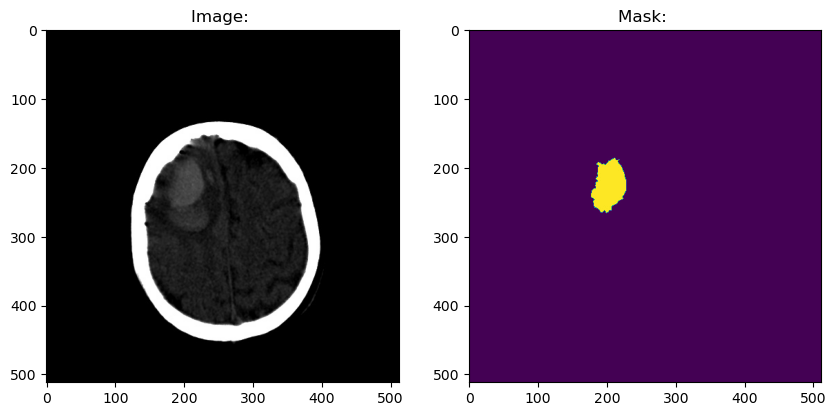

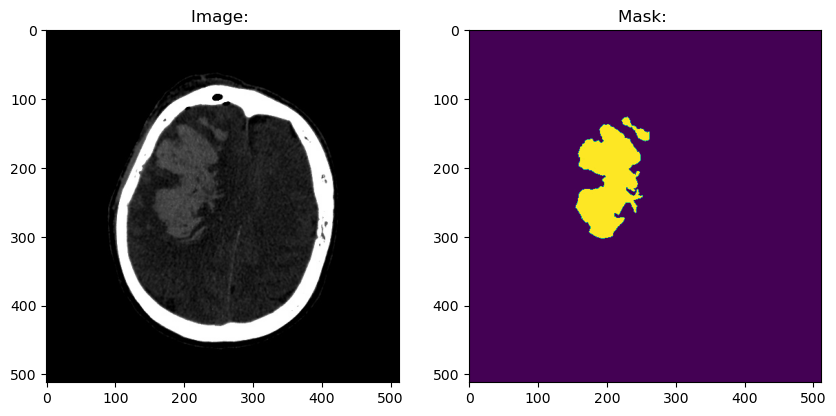

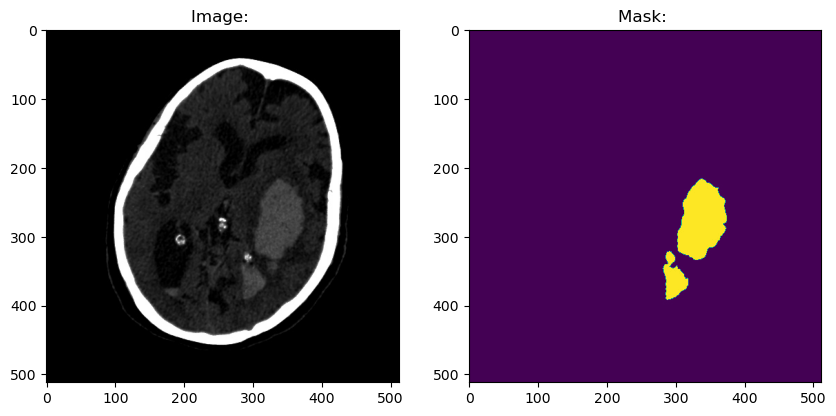

In [82]:
for idx in range(8000, 8025):
    img = Image.open(f'/kaggle/input/innopolis-global-ai-challenge-2023-ai4med/competition/competition/00{idx}.jpg').convert("RGB")
    img = img.rotate(270, PIL.Image.NEAREST, expand = 1)
    mask_img = Image.open(f'/kaggle/working/competition/masks/00{idx}.jpg').convert("L")
    mask_img = mask_img.rotate(270, PIL.Image.NEAREST, expand = 1)
    show_examples(name="", image=img, mask=mask_img)

## Prepare data to load format for this challange

In [94]:
# функция которая  принимает картинку и создает список с значениями 0 или 1 для каждого пикселя маски
def convet_image_to_submit(img_name, img):
    lst = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            lst.append([f'{img_name}_{i}_{j}', int(img[i][j])])
    return lst

In [95]:
full_list = []
for idx in range(8000, 8025):
    mask_img = np.array(Image.open(f'/kaggle/working/result/00{idx}.jpg').convert("L"), dtype=np.float32)
    submit = convet_image_to_submit(f'00{idx}', mask_img)
    full_list.extend(submit)

In [96]:
df = pd.DataFrame(full_list, columns =['ID', 'Value'])
df

ID  Value
0            008000_0_0      0
1            008000_0_1      0
2            008000_0_2      0
3            008000_0_3      0
4            008000_0_4      0
...                 ...    ...
6553595  008024_511_507      0
6553596  008024_511_508      0
6553597  008024_511_509      0
6553598  008024_511_510      0
6553599  008024_511_511      0

[6553600 rows x 2 columns]

In [97]:
df.to_csv('cv1.csv', index=False)